In [1]:
using QuadGK,Plots,LaTeXStrings;
using NLsolve;

In [2]:
include("./LSE/onshell/libs/constants.jl");

In [3]:
function Dπ(M,p,q,z;mπ=mπc,mi=mDn,mj=mDn,mis=mDsn,mjs=mDsn)
    return (-1/(2mπ)*(1/(mi+mj+mπ+p^2/(2*mi)+q^2/(2mj)+(p^2+q^2-2*p*q*z)/(2mπ)-M-im*eps())+1/(mis+mjs+mπ+p^2/(2*mis)+q^2/(2mjs)+(p^2+q^2-2*p*q*z)/(2mπ)-M-im*eps())))
end

Dπ (generic function with 1 method)

In [4]:
function integral(f;a=1.0)
    res=zero(ComplexF64)
    res+=quadgk(f,-1,-1-a*im)[1]
    res+=quadgk(f,-1-a*im,1-a*im)[1]
    res+=quadgk(f,1-a*im,1)[1]
    return res 
end

integral (generic function with 1 method)

In [5]:
function integrandss(M,p,q,z)
    return (p^2+q^2-2*p*q*z)*Dπ(M,p,q,z)
end

function integrandsd(M,p,q,z)
    return (1/2*p^2*(3z^2-1)+q^2-2*p*q*z)*Dπ(M,p,q,z)
end

function integrandds(M,p,q,z)
    return (p^2+1/2*q^2*(3z^2-1)-2*p*q*z)*Dπ(M,p,q,z)
end

function integranddd(M,p,q,z)
    return (2(p^2+q^2)*(3z^2-1)-p*q*z*(9*z^2-1))*Dπ(M,p,q,z)
#     return (2(p^2+q^2)*(3z^2-1))*Dπ(M,p,q,z)
end

integranddd (generic function with 1 method)

In [6]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    @assert sol.residual_norm < 1e-8 "The on-shell momentum not found!"
    return sol.zero[1] + im * sol.zero[2]
#     return sol.residual_norm < 1e-8 ? sol.zero[1] + im * sol.zero[2] : NaN+im*NaN
end

qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [7]:
qon_c(3.875+im*eps())|>println
qon_c(3.875-im*eps())|>println

0.0029372246221008136 + 0.014184313944713145im
0.002937224622071771 + 0.014184313944707129im


In [8]:
function integrandss(M,z)
    p=qon_c(M)
    return integrandss(M,p,p,z)
end
function integrandsd(M,z)
    p=qon_c(M)
    return integrandsd(M,p,p,z)
end
function integrandds(M,z)
    p=qon_c(M)
    return integrandds(M,p,p,z)
end
function integranddd(M,z)
    p=qon_c(M)
    return integranddd(M,p,p,z)
end

integranddd (generic function with 2 methods)

In [9]:
integral(z->integrandss(3.875,z))

-0.36336666438998033 + 0.11307741347605005im

In [10]:
function V(M;a=1.0)
    res=zeros(ComplexF64,2,2)
    res[1,1]=integral(z->integrandss(M,z);a=a)
    res[1,2]=integral(z->integrandsd(M,z);a=a)*(-√2)
    res[2,1]=integral(z->integrandds(M,z);a=a)*(-√2)
    res[2,2]=integral(z->integranddd(M,z);a=a)/2
    res .*g^2/(6fπ^2)
end

V (generic function with 1 method)

In [12]:
V(3.875;a=10)

2×2 Matrix{ComplexF64}:
  -1.2099+0.376514im   0.804229-0.229097im
 0.804229-0.229097im  0.0759182-0.0523295im

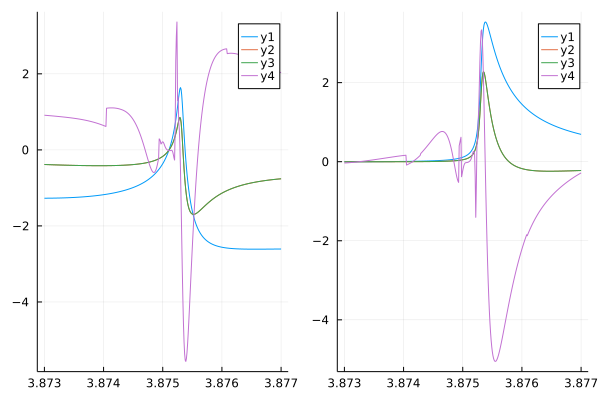

In [25]:
let Ev=collect(3.873:0.00001:3.877)
    res=V.(Ev)
    p1=plot(Ev,[real(res[i][1,1]) for i in eachindex(res)])
    plot!(Ev,[real(res[i][1,2]) for i in eachindex(res)])
    plot!(Ev,[real(res[i][2,1]) for i in eachindex(res)])
    plot!(Ev,[real(res[i][2,2]) for i in eachindex(res)])
    p2=plot(Ev,[imag(res[i][1,1]) for i in eachindex(res)])
    plot!(Ev,[imag(res[i][1,2]) for i in eachindex(res)])
    plot!(Ev,[imag(res[i][2,1]) for i in eachindex(res)])
    plot!(Ev,[imag(res[i][2,2]) for i in eachindex(res)])
    plot(p1,p2)
end

In [26]:
V(mDn+mDsc-360e-6-im*24e-6)

2×2 Matrix{ComplexF64}:
 -0.795376+0.0174749im   -0.332393+0.00545339im
 -0.332393+0.00545339im  -0.279115+0.788363im

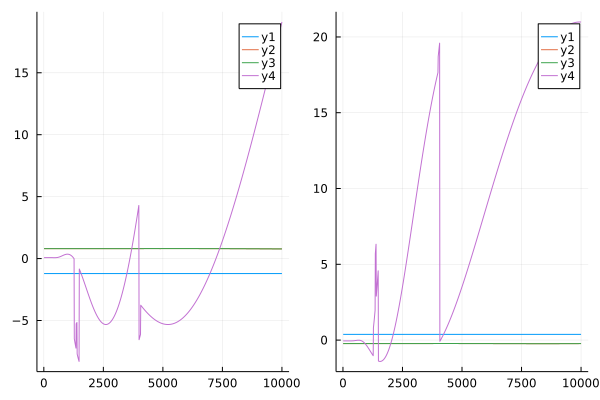

In [49]:
let av=collect(10:10:10000),E=3.875
    resv=[V(E;a=ai) for ai in av]
    p1=plot(av,[real(resv[i][1,1]) for i in eachindex(resv)])
    plot!(av,[real(resv[i][1,2]) for i in eachindex(resv)])
    plot!(av,[real(resv[i][2,1]) for i in eachindex(resv)])
    plot!(av,[real(resv[i][2,2]) for i in eachindex(resv)])
    p2=plot(av,[imag(resv[i][1,1]) for i in eachindex(resv)])
    plot!(av,[imag(resv[i][1,2]) for i in eachindex(resv)])
    plot!(av,[imag(resv[i][2,1]) for i in eachindex(resv)])
    plot!(av,[imag(resv[i][2,2]) for i in eachindex(resv)])
    plot(p1,p2)
end

In [45]:
integral(z->z^2;a=100000)

0.6666641235351562 + 0.0im